In [1]:
%cd /home/x_amime/x_amime/projects/an_explanation_model/

/proj/azizpour-group/users/x_amime/projects/an_explanation_model


/home/x_amime/x_amime/envs/.conda/envs/xlab/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import pandas as pd
import seaborn as sns
from glob import glob
import PIL
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import ttest_ind_from_stats as ttest
from source.project_manager import load_experiment_metadata
from source.data_manager import preprocess, save_axis

# run this without ? to comput aucs for an experiment
# run this with ? to merge
# run this with ? twice to merge aucs accross experiments
save_metadata_dir = "outputs/metadata/8_?_*/"

imshow_args = {"cmap": "jet"}

2024-04-12 10:22:58.894398: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-12 10:22:58.895620: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-12 10:22:59.028732: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-12 10:22:59.385307: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 10:23:02.619157: W tensorflow/compiler/tf2

In [19]:
path_to_acc_data = "outputs/processed/8/8_acc_data.csv"
index_cols = [
    "alpha_mask_value",
    "q_direction",
    "q_baseline_mask",
    "combination",
    "projection_type",
    "batch",
]
static_data_acc = pd.read_csv(
    "outputs/processed/8/8_static_acc_data.csv",
    index_col=index_cols,
)
static_data_acc.columns = static_data_acc.columns.astype(int)


def fill_na():
    alphas = merged_data_acc.index.get_level_values("alpha_mask_value").unique()
    for alpha in alphas:
        q_directions = (
            merged_data_acc.loc[alpha].index.get_level_values("q_direction").unique()
        )
        for q_direction in q_directions:
            q_baseline_masks = (
                merged_data_acc.loc[alpha, q_direction]
                .index.get_level_values("q_baseline_mask")
                .unique()
            )
            for q_baseline_mask in q_baseline_masks:
                combinations = (
                    merged_data_acc.loc[alpha, q_direction, q_baseline_mask]
                    .index.get_level_values("combination")
                    .unique()
                )
                for combination in combinations:
                    # select the key that is computed for 0 and 100
                    temp = static_data_acc.loc[
                        ("ig_vg_u_x_0", "deletion", q_baseline_mask, "additive"),
                        [0, 100],
                    ]

                    # check if there are any nan values in the selected key
                    assert (
                        temp.isna().sum().sum() == 0
                    ), f"alpha: {alpha}, q_direction: {q_direction}, q_baseline_mask: {q_baseline_mask}, combination: {combination}"

                    # check if the index of the selected key is the same as the index of the merged_data_acc
                    index2 = temp.index
                    index1 = merged_data_acc.loc[
                        (alpha, q_direction, q_baseline_mask, combination), [0, 100]
                    ].index
                    assert (
                        index1.shape == index2.shape
                    ), f"shape mismatch {index1.shape}!={index2.shape} at alpha: {alpha}, q_direction: {q_direction}, q_baseline_mask: {q_baseline_mask}, combination: {combination}"
                    assert (
                        index1 != index2
                    ).sum() == 0, f"alpha: {alpha}, q_direction: {q_direction}, q_baseline_mask: {q_baseline_mask}, combination: {combination}"

                    # if the q_direction is insertion, we need to swap the columns
                    if q_direction == "insertion":
                        temp = temp.rename(columns={0: 100, 100: 0})
                        temp = temp[[0, 100]]

                    # replace the values in the merged_data_acc with the selected key
                    merged_data_acc.loc[
                        (alpha, q_direction, q_baseline_mask, combination), [0, 100]
                    ] = temp.values

    merged_data_acc.to_csv(path_to_acc_data)


if os.path.exists(path_to_acc_data):
    merged_data_acc = pd.read_csv(
        path_to_acc_data,
        index_col=index_cols,
    ).sort_index()
    merged_data_acc.columns = merged_data_acc.columns.astype(int)
    if 0 not in merged_data_acc.columns:
        merged_data_acc[0] = np.nan
    if 100 not in merged_data_acc.columns:
        merged_data_acc[100] = np.nan
    merged_data_acc = merged_data_acc.sort_index(axis=1)
    print("loaded acc data previously computed")
    num_na = merged_data_acc.isna().sum().sum()
    if num_na > 0:
        fill_na()
        print("filled na in the acc data")
    else:
        print("number of nan in acc data:", num_na)
elif "?" not in save_metadata_dir:
    paths = os.path.join(save_metadata_dir, "merged_igq_metadata.csv")
    paths = glob(paths)
    print(paths)
    merged_data = []
    for path in paths:
        slq_csv = pd.read_csv(path)
        batch = path.split("/")[-2].split("_")[-1]
        slq_csv["batch"] = batch

        if "additive" in path:
            slq_csv["combination"] = "additive"
        elif "convex" in path:
            slq_csv["combination"] = "convex"
        elif "damping" in path:
            slq_csv["combination"] = "damping"
        else:
            slq_csv["combination"] = None

        merged_data.append(slq_csv)
    merged_data = pd.concat(merged_data, axis=0)

    merged_data_acc = merged_data.pivot_table(
        index=index_cols,
        columns="q",
        values="preds",
        aggfunc="mean",
    )
    merged_data_acc.to_csv(path_to_acc_data)
    print("computed acc data you need to run this cell again with ? to merge")
else:
    paths = glob("outputs/processed/8/8_?_acc_data.csv")
    merged_data_acc = []
    for path in paths:
        merged_data_acc.append(
            pd.read_csv(
                path,
                index_col=index_cols,
            ).sort_index()
        )
    print("concatenating acc data from different runs")
    merged_data_acc = pd.concat(merged_data_acc, axis=0)
    merged_data_acc.to_csv(path_to_acc_data)
    print("saved merged acc data please rerun this cell to fill na")

loaded acc data previously computed
number of nan in acc data: 0


In [20]:
def auc(x):
    return np.trapz(y=x.values, x=[int(x) / 100 for x in x.index])


nice_names = {
    "ig_sg_i_u_x2_0_0.2": "XSL$^2(0,0.2)$",
    "ig_sg_i_u_x2_0_0.4": "XSL$^2(0,0.4)$",
    "ig_sg_i_u_x2_0_0.5": "XSL$^2(0,0.5)$",
    "ig_sg_i_u_x2_0_0.8": "XSL$^2(0,0.8)$",
    "ig_sg_i_u_x2_0_1.0": "XSL$^2(0,1.0)$",
    "ig_sg_i_u_x_0_0.2": "XSL(0,0.2)",
    "ig_sg_i_u_x_0_0.4": "XSL(0,0.4)",
    "ig_sg_i_u_x_0_0.5": "XSL(0,0.5)",
    "ig_sg_i_u_x_0_0.8": "XSL(0,0.8)",
    "ig_sg_i_u_x_0_1.0": "XSL(0,1.0)",
    "ig_sg_u_x2_0_0.1": "SL$^2(0,0.1)$",
    "ig_sg_u_x2_0_0.2": "SL$^2(0,0.2)$",
    "ig_sg_u_x2_0_0.5": "SL$^2(0,0.5)$",
    "ig_sg_u_x2_0_0.8": "SL$^2(0,0.8)$",
    "ig_sg_u_x2_0_1.0": "SL$^2(0,1.0)$",
    "ig_sg_u_x_0_0.1": "SL(0,0.1)",
    "ig_sg_u_x_0_0.2": "SL(0,0.2)",
    "ig_sg_u_x_0_0.5": "SL(0,0.5)",
    "ig_sg_u_x_0_0.8": "SL(0,0.8)",
    "ig_sg_u_x_0_1.0": "SL(0,1.0)",
    "sl_u_x2_0_0.2": "SLT$^2$(0,0.2)",
    "sl_u_x2_0_0.4": "SLT$^2$(0,0.4)",
    "sl_u_x2_0_0.5": "SLT$^2$(0,0.5)",
    "sl_u_x2_0_0.8": "SLT$^2$(0,0.8)",
    "sl_u_x2_0_1.0": "SLT$^2$(0,1.0)",
    "ig_sg_u_x2_0.1": "SG$^2$(0.1)",
    "ig_sg_u_x2_0.2": "SG$^2$(0.2)",
    "ig_sg_u_x2_0.5": "SG$^2$(0.5)",
    "ig_sg_u_x2_1.0": "SG$^2$(1.0)",
    "ig_sg_u_x_0.1": "SG(0.1)",
    "ig_sg_u_x_0.2": "SG(0.2)",
    "ig_sg_u_x_0.5": "SG(0.5)",
    "ig_sg_u_x_1.0": "SG(1.0)",
    "ig_vg_u_x_0": "SG(0.0)",  
    "ig_vg_u_x2_0": "SG$^2$(0.0)",
    "ig_u_x_0": "IG(0.0)",
    "ig_u_x_0.1": "IG(0.1)",
    "ig_u_x_0.2": "IG(0.2)",
    "ig_u_x_0.5": "IG(0.5)",
    "ig_u_x_1.0": "IG(1.0)",
    "ig_u_x2_0": "IG$^2$(0.0)",
    "ig_u_x2_0.1": "IG$^2$(0.1)",
    "ig_u_x2_0.2": "IG$^2$(0.2)",
    "ig_u_x2_0.5": "IG$^2$(0.5)",
    "ig_u_x2_1.0": "IG$^2$(1.0)",
    "ig_u_x2_0_0.2": "IG$^2$(0,0.2)",
    "ig_u_x2_0_0.5": "IG$^2$(0,0.5)",
    "ig_u_x2_0_1.0": "IG$^2$(0,1.0)",
    "ig_u_x2_i_0_0.2": "XIG$^2$(0,0.2)",
    "ig_u_x2_i_0_0.5": "XIG$^2$(0,0.5)",
    "ig_u_x2_i_0_1.0": "XIG$^2$(0,1.0)",
    "ig_u_x_0_0.2": "IG(0,0.2)",
    "ig_u_x_0_0.5": "IG(0,0.5)",
    "ig_u_x_0_1.0": "IG(0,1.0)",
    "ig_u_x_i_0_0.2": "XIG(0,0.2)",
    "ig_u_x_i_0_0.5": "XIG(0,0.5)",
    "ig_u_x_i_0_1.0": "XIG(0,1.0)",
    "ig_occlusion_u_x_nan": "Occlusion",
    "ig_occlusion_u_x2_nan": "Occlusion$^2$",
    "ig_rise_u_x_0.1": "RISE(0.1)",
    "ig_rise_u_x2_0.1": "RISE(0.1)$^2$",
}

aucs = merged_data_acc.apply(lambda x: auc(x), axis=1)
aucs.name = "AUC"
alphas = aucs.index.get_level_values("alpha_mask_value").unique()
aucs = aucs.reset_index()
aucs = aucs.pivot_table(
    index=["alpha_mask_value"],
    columns=["projection_type", "q_direction", "q_baseline_mask", "combination"],
    values="AUC",
    aggfunc=["mean", "std"],
)
f_ = lambda x: f"{x:.3f}"

In [13]:
# apply ttest to the aucs
def significance_test(data: pd.Series):
    q_direction = data.index.get_level_values("q_direction").unique()
    assert len(q_direction) == 1, "q_direction should be unique"
    q_direction = q_direction[0]
    if q_direction == "insertion":
        target_fn = np.argmax
    else:
        target_fn = np.argmin
    data = data.droplevel("q_direction")
    data = data.unstack(level=0)
    target_id = target_fn(data["mean"])
    target_mean = data["mean"].iloc[target_id]
    target_std = data["std"].iloc[target_id]
    ttests = data.apply(
        lambda x: ttest(target_mean, target_std, 10, x["mean"], x["std"], 10).pvalue,
        axis=1,
    )
    ttests = (ttests > 0.05).astype(int)
    ttests.iloc[target_id] = 2
    return ttests

ttests = (
    aucs.stack(level=(0, 2, 4))
    .reorder_levels([2, 1, 3, 0])
    .sort_index()
    .groupby("q_direction")
    .apply(lambda x: x.apply(significance_test, axis=0))
)
ttests = ttests.unstack(level=0)
aucs = aucs.stack(level=(4)).reorder_levels([1, 0], axis=0).sort_index()
aucs = aucs.reorder_levels([0, 1, 3, 2], axis=1).sort_index(axis=1)
aucs = aucs.rename(index=nice_names)
aucs = aucs.sort_index()
ttests = ttests.rename(index=nice_names)
ttests = ttests.sort_index()

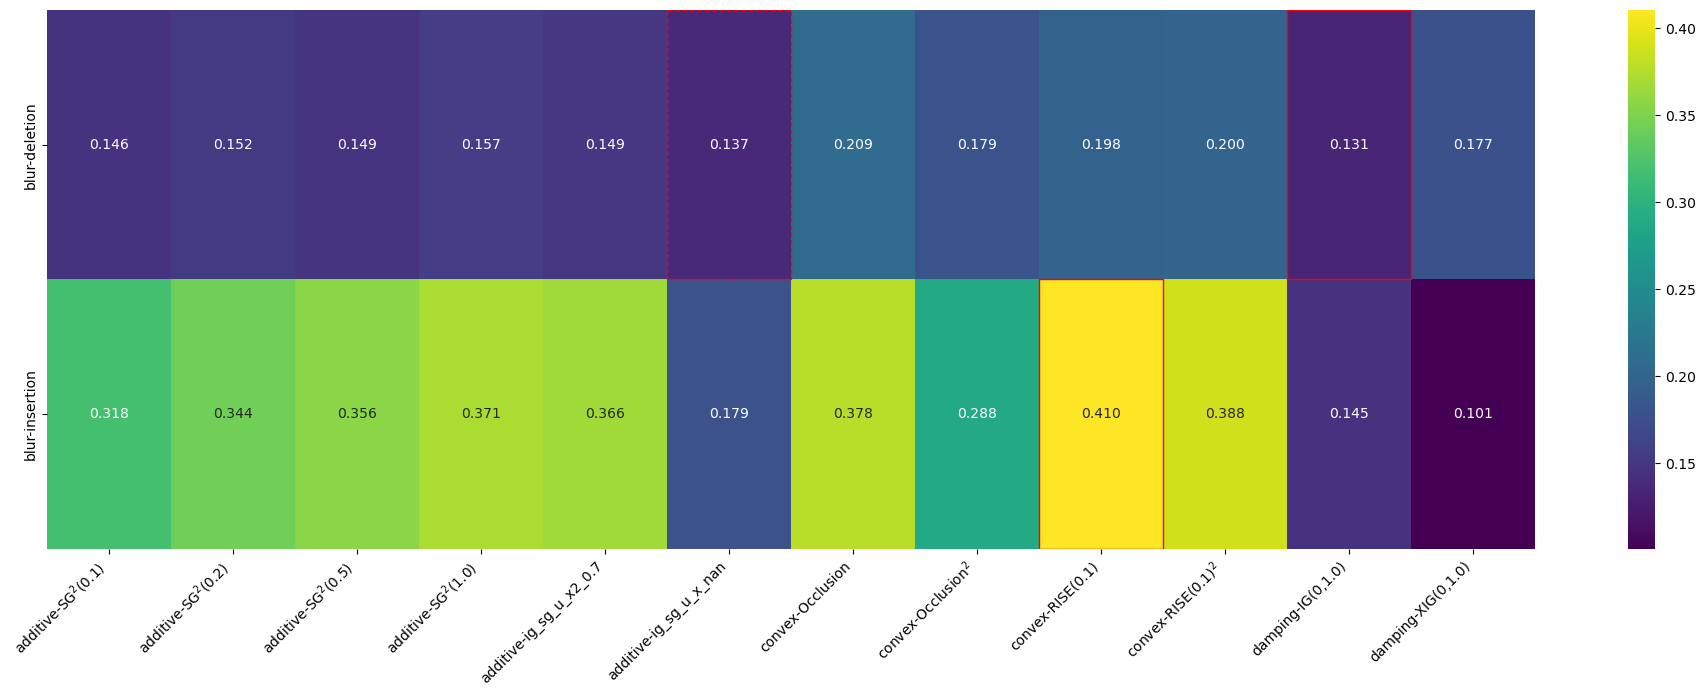

In [14]:
fig, axes = plt.subplots(
    1,
    1,
    figsize=(24, 7),
    sharey=True,
)
temp = aucs[("mean", "prediction")]
sns.heatmap(
    temp.T,
    annot=True,
    fmt=".3f",
    ax=axes,
    cmap="viridis",
)

# rotate labes

axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha="right")
axes.set_xlabel("")
axes.set_ylabel("")


# highlight the significant differences
def add_patches(_ttests, ax):
    for i in range(_ttests.loc["prediction"].shape[0]):
        for j in range(_ttests.loc["prediction"].shape[1]):
            if _ttests.loc["prediction"].iloc[i, j] == 1:
                ax.add_patch(
                    plt.Rectangle(
                        (j, i), 1, 1, fill=False, edgecolor="red", linestyle="dashed"
                    )
                )
            elif _ttests.loc["prediction"].iloc[i, j] == 2:
                ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor="red"))


add_patches(ttests.T, ax=axes)
# plt.savefig("outputs/figures/8_auc_heatmap.pdf", bbox_inches="tight")

In [40]:
occlusion = aucs.loc["ig_occlusion_u_x_nan",(slice(None),"prediction",slice(None),"blur","convex")].unstack(level=0)
# make it like mean+-std
occlusion = occlusion.map(f_)
occlusion = occlusion.apply(lambda x: f"{x['mean']}\\pm{x['std']}", axis=1)
occlusion

projection_type  q_direction  q_baseline_mask  combination
prediction       deletion     blur             convex         0.209\pm0.009
                 insertion    blur             convex         0.378\pm0.011
dtype: object

In [41]:
rise = aucs.loc["ig_rise_u_x_0.1",(slice(None),"prediction",slice(None),"blur","convex")].unstack(level=0)
# make it like mean+-std
rise = rise.map(f_)
rise = rise.apply(lambda x: f"{x['mean']}\\pm{x['std']}", axis=1)
rise

projection_type  q_direction  q_baseline_mask  combination
prediction       deletion     blur             convex         0.198\pm0.007
                 insertion    blur             convex         0.410\pm0.013
dtype: object

In [63]:
xig = aucs.loc["ig_u_x_i_0_1.0",(slice(None),"prediction",slice(None),"blur","damping")].unstack(level=0)
# make it like mean+-std
xig = xig.map(f_)
xig = xig.apply(lambda x: f"{x['mean']}\\pm{x['std']}", axis=1)
xig

projection_type  q_direction  q_baseline_mask  combination
prediction       deletion     blur             damping        0.177\pm0.007
                 insertion    blur             damping        0.101\pm0.004
dtype: object

In [17]:
xig2 = aucs.loc["ig_u_x2_i_0_1.0",(slice(None),"prediction",slice(None),"blur","damping")].unstack(level=0)
# make it like mean+-std
xig2 = xig2.map(f_)
xig2 = xig2.apply(lambda x: f"{x['mean']}\\pm{x['std']}", axis=1)
xig2

projection_type  q_direction  q_baseline_mask  combination
prediction       deletion     blur             damping        0.263\pm0.007
                 insertion    blur             damping        0.204\pm0.010
dtype: object

In [18]:
ig = aucs.loc["ig_u_x_0_1.0",(slice(None),"prediction",slice(None),"blur","damping")].unstack(level=0)
# make it like mean+-std
ig = ig.map(f_)
ig = ig.apply(lambda x: f"{x['mean']}\\pm{x['std']}", axis=1)
ig

projection_type  q_direction  q_baseline_mask  combination
prediction       deletion     blur             damping        0.145\pm0.006
                 insertion    blur             damping        0.131\pm0.005
dtype: object

In [44]:
ig2 = aucs.loc["ig_u_x2_0_1.0",(slice(None),"prediction",slice(None),"blur","damping")].unstack(level=0)
# make it like mean+-std
ig2 = ig2.map(f_)
ig2 = ig2.apply(lambda x: f"{x['mean']}\\pm{x['std']}", axis=1)
ig2

projection_type  q_direction  q_baseline_mask  combination
prediction       deletion     blur             damping        0.135\pm0.005
                 insertion    blur             damping        0.320\pm0.009
dtype: object

In [45]:
osg = aucs.loc["ig_sg_u_x2_0.5",(slice(None),"prediction",slice(None),"blur","convex")].unstack(level=0)
# make it like mean+-std
osg = osg.map(f_)
osg = osg.apply(lambda x: f"{x['mean']}\\pm{x['std']}", axis=1)
osg


projection_type  q_direction  q_baseline_mask  combination
prediction       deletion     blur             convex         0.161\pm0.005
                 insertion    blur             convex         0.385\pm0.014
dtype: object

In [46]:
osg = aucs.loc["og_sg_u_x2_nan",(slice(None),"prediction",slice(None),"blur","convex")].unstack(level=0)
# make it like mean+-std
osg = osg.map(f_)
osg = osg.apply(lambda x: f"{x['mean']}\\pm{x['std']}", axis=1)
osg

projection_type  q_direction  q_baseline_mask  combination
prediction       deletion     blur             convex         0.167\pm0.006
                 insertion    blur             convex         0.394\pm0.013
dtype: object

In [50]:
sg = aucs.loc["ig_sg_u_x_nan",(slice(None),"prediction",slice(None),"blur","additive")].unstack(level=0)
# make it like mean+-std
sg = sg.map(f_)
sg = sg.apply(lambda x: f"{x['mean']}\\pm{x['std']}", axis=1)
sg

projection_type  q_direction  q_baseline_mask  combination
prediction       deletion     blur             additive       0.137\pm0.007
                 insertion    blur             additive       0.179\pm0.008
dtype: object

In [48]:
sg2 = aucs.loc["ig_sg_u_x2_nan",(slice(None),"prediction",slice(None),"blur","additive")].unstack(level=0)
# make it like mean+-std
sg2 = sg2.map(f_)
sg2 = sg2.apply(lambda x: f"{x['mean']}\\pm{x['std']}", axis=1)
sg2

projection_type  q_direction  q_baseline_mask  combination
prediction       deletion     blur             additive       0.162\pm0.006
                 insertion    blur             additive       0.371\pm0.012
dtype: object

In [ ]:
igsg = aucs.loc["ig_sg_u_x2_0_1.0",(slice(None),"prediction",slice(None),"blur","additive")].unstack(level=0)
# make it like mean+-std
igsg = igsg.map(f_)
igsg = igsg.apply(lambda x: f"{x['mean']}\\pm{x['std']}", axis=1)
igsg


In [50]:
igsg = aucs.loc["ig_sg_u_x2_0_1.0",(slice(None),"prediction",slice(None),"blur","convex")].unstack(level=0)
# make it like mean+-std
igsg = igsg.map(f_)
igsg = igsg.apply(lambda x: f"{x['mean']}\\pm{x['std']}", axis=1)
igsg


projection_type  q_direction  q_baseline_mask  combination
prediction       deletion     blur             convex         0.157\pm0.007
                 insertion    blur             convex         0.395\pm0.014
dtype: object

# JUNK YARD

In [3]:
from source.data_manager import single_query_curated_breast_imaging_ddsm

metadata = load_experiment_metadata("outputs/metadata/8_0_*")
dataset_dir = "/proj/azizpour-group/datasets/CBIS-DDSM/builder/"

In [76]:
preds = metadata.loc[
    (metadata.stream_name == "log_probs") & (metadata.alpha_mask_value < 0.1),
    "data_path",
].apply(lambda x: np.load(x))
entropies = preds.apply(lambda x: -np.sum(x * np.exp(x)))

In [74]:
metadata.alpha_mask_value.unique()

array([0.  , 0.07, 0.08, 0.5 , 0.01, 0.02, 0.03, 0.04, 0.09, 0.6 ])

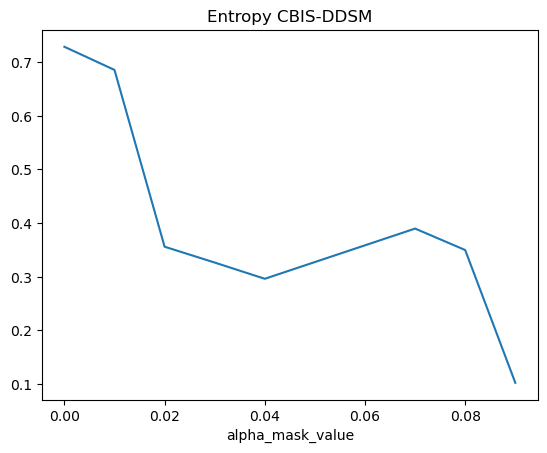

In [77]:
entropies.groupby(metadata.alpha_mask_value).mean().plot()
plt.title("Entropy CBIS-DDSM")
plt.savefig("outputs/figures/8_entropy_1.pdf", bbox_inches="tight")

In [24]:
temp = metadata[(metadata.stream_name=="vanilla_grad_mask") & (metadata.stream_statistic == "meanx2")]

In [68]:
indx=10
v = 0.02
image, label, image_path = single_query_curated_breast_imaging_ddsm(dataset_dir=dataset_dir, skip=indx, input_shape=(224, 224, 1))
e = np.load(temp[
    (temp.alpha_mask_value == v)
    & (temp.image_index == indx)
].iloc[0].data_path)
p = np.load(metadata[
    (metadata.stream_name == "log_probs")
    & (metadata.alpha_mask_value == v)
    & (metadata.image_index == indx)
].iloc[0].data_path)
l = metadata[
    (metadata.stream_name == "log_probs")
    & (metadata.alpha_mask_value == v)
    & (metadata.image_index == indx)
]["label"].values
print([f"{u:.2f}" for u in np.exp(p)],np.exp(p).sum())
print(l)

['0.00', '0.00', '0.00', '1.00', '0.00'] 0.9998041
[0]


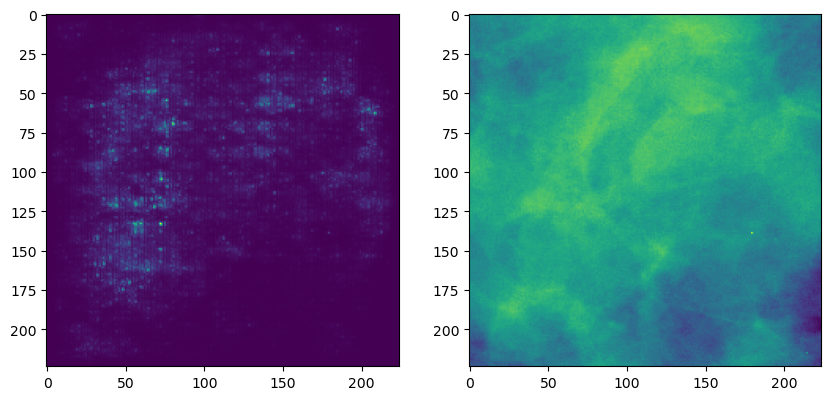

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(e)
axes[1].imshow(image)

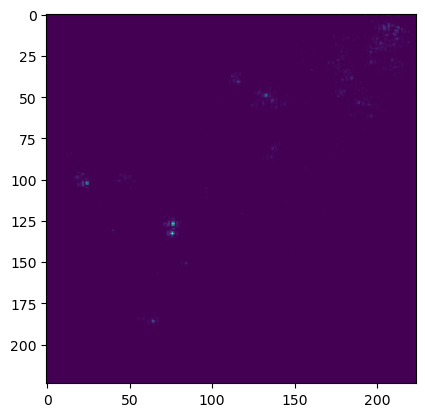

In [42]:
plt.imshow(e)